# Clustering networks

In [1]:
import pickle
import warnings
warnings.filterwarnings('ignore')
from matplotlib.axes._axes import _log
_log.setLevel('ERROR')

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from collections import Counter
from hdbscan import HDBSCAN
from matplotlib.cm import get_cmap
from sklearn.manifold import spectral_embedding
from umap import UMAP

%matplotlib inline

seed = 42

Defining the network:

In [2]:
np.random.seed(seed)

with open("data/imdb.p", "rb") as f:
    G = nx.Graph()
    G.add_edges_from(pickle.load(f))

G.remove_nodes_from(set(nx.nodes(G)) - max(nx.connected_components(G), key=len))

largest connected components: [77744, 121, 100, 76, 51]


Reducing dimensions with Spectral Embedding and UMAP and clustering with HDBSCAN:

In [3]:
np.random.seed(seed)

adj_matrix = nx.to_numpy_array(G)
node_list = list(G.nodes())

embedding = spectral_embedding(adj_matrix, n_components=200, drop_first=False, random_state=np.random.RandomState(seed))
embedding = UMAP(
    n_components=2, n_neighbors=30, min_dist=0.0, random_state=np.random.RandomState(seed)
).fit_transform(embedding)
clusters = HDBSCAN(min_samples=500, min_cluster_size=500, core_dist_n_jobs=-1).fit_predict(embedding)

print(f"nodes: {len(node_list)}")
counter = Counter(clusters)
print(f"clusters: {len(counter) - 1}")
print(f"cluster sizes: {sorted(counter.items(), key=lambda x: x[1], reverse=True)}")
print(f"noise level: {np.round(counter[-1] / len(clusters), 3)}")

nodes: 77744
clusters: 13
cluster sizes: [(-1, 31242), (12, 17399), (1, 7659), (5, 3555), (10, 2943), (11, 2374), (0, 2288), (3, 1770), (2, 1756), (7, 1723), (8, 1355), (9, 1305), (6, 1221), (4, 1154)]
noise level: 0.402


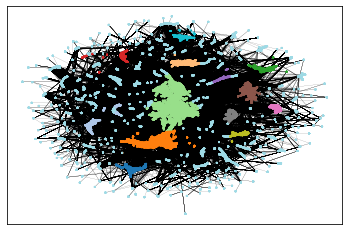

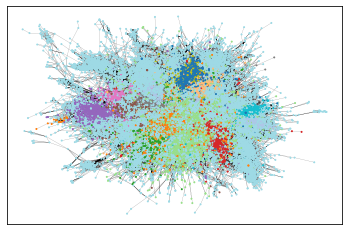

In [4]:
np.random.seed(seed)

cmap = get_cmap("tab20").colors
cmap = [cmap[i] for i in range(len(cmap)) if i % 2 == 0] + [cmap[i] for i in range(len(cmap)) if i % 2 == 1]
node_colors = [cmap[cluster] for cluster in clusters]

pos_su = {node_list[i]: embedding[i] for i in range(len(node_list))}
pos_fr = nx.fruchterman_reingold_layout(G, seed=seed)

def draw_network(G, pos, node_colors, pdf_name, edge_width=.1, font_size=1):
    # degrees = [x[1] for x in nx.degree(G)]
    # node_sizes = [50 * x / max(degrees) + 1 for x in degrees]
    nx.draw_networkx_nodes(G, pos=pos, node_size=1, node_color=node_colors)
    nx.draw_networkx_edges(G, pos=pos, width=edge_width)
    # nx.draw_networkx_labels(G, pos=pos, font_size=font_size)
    plt.savefig(f"results/{pdf_name}.pdf")
    plt.show()

draw_network(G, pos=pos_su, node_colors=node_colors, pdf_name="graph_su_2")
draw_network(G, pos=pos_fr, node_colors=node_colors, pdf_name="graph_fr_2")

Removing nodes labeled as noise by HDBSCAN:

In [5]:
G.remove_nodes_from([node_list[i] for i in range(len(node_list)) if clusters[i] == -1])
node_colors = [cmap[cluster] for cluster in clusters if cluster != -1]

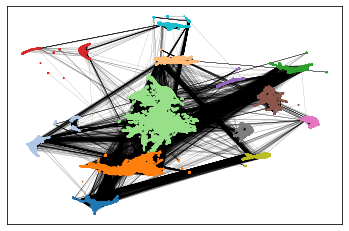

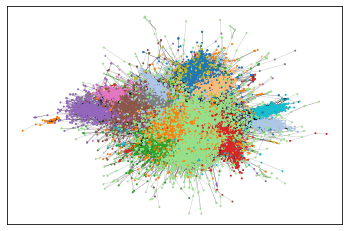

In [6]:
draw_network(G, pos=pos_su, node_colors=node_colors, pdf_name="graph_su_clean_2")
draw_network(G, pos=pos_fr, node_colors=node_colors, pdf_name="graph_fr_clean_2")